### Analysis of CycIF data from PTCL

In [1]:
# Import librarires
import pandas as pd
import numpy as np
import os
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt

# Create anndata and scanpy
import anndata as ad
import scanpy as sc

# Import custom functions
import wget

#### Import data

In [2]:
# Set working directory
# Laptop
WD = "/Users/aj/Dropbox (Partners HealthCare)/Data/Vignesh_Lymphoma_tma"
# HMS
#WD = "C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/Vignesh_Lymphoma_tma"

os.chdir(WD)
data = pd.read_csv('data.csv', delimiter=',', index_col=0)
data_n = pd.read_csv('data_n.csv', delimiter=',', index_col=0)

#### Look at the head of data

In [3]:
data_n.head()

,DAPI,BACK,CD2,TCR,DAPI02,CD4,CD3D,CD7,DAPI03,CD43,...,BACK.1,BCL6,DAPI12,EBVLMP,BACK.2,CD31,DAPI13,CD16,BACK.3,PSTAT3
ID,,,,,,,,,,,,,,,,,,,,,
1_1,-0.77408,-0.813440,-0.406640,0.231810,-0.72973,-0.61038,-0.245100,-0.39460,-0.53386,-0.35536,...,-0.734600,-0.88867,-0.65152,-0.365380,-0.062879,-0.37063,-0.81677,-0.517090,-0.380750,-0.27502
1_2,-0.41498,-0.543310,-0.208120,0.353310,-0.43281,-0.40702,-0.143160,-0.32192,-0.52460,-0.40222,...,-0.582820,-0.69078,-0.50177,-0.158590,-0.009512,-0.36016,-0.51564,-0.296570,-0.510360,-0.23356
1_3,-0.29421,-0.603260,-0.345370,0.028613,-0.24807,-0.46394,-0.186560,-0.37300,-0.28226,-0.20602,...,-0.682640,-0.69435,-0.39666,-0.355140,-0.173440,-0.37063,-0.36210,-0.376790,-0.256640,-0.22695
1_4,-0.34965,-0.177980,-0.120140,0.219100,-0.43411,-0.35657,-0.072530,-0.30623,-0.30229,0.01909,...,-0.397670,-0.58655,-0.33517,0.217390,0.192470,-0.34998,-0.44701,-0.121790,0.086801,-0.17680
1_5,-0.51498,0.077066,-0.031985,-0.049000,-0.43804,-0.19408,-0.050959,-0.28056,-0.56836,-0.22607,...,-0.074121,-0.45637,-0.57638,0.064211,0.631770,-0.34009,-0.57981,0.028438,0.394020,-0.12005


#### Remove DAPI and background channels

In [4]:
# Drop DAPI
data_n = data_n.drop(list(data_n.filter(regex='DAPI|BACK', axis=1)), axis=1)
data_n.head()

,CD2,TCR,CD4,CD3D,CD7,CD43,ALK,CD45,CD10,KI67,...,CD21,S6P,ERK,TBET,TDT,BCL6,EBVLMP,CD31,CD16,PSTAT3
ID,,,,,,,,,,,,,,,,,,,,,
1_1,-0.406640,0.231810,-0.61038,-0.245100,-0.39460,-0.35536,-0.410740,-0.058780,-0.990550,-0.075095,...,-0.39021,-0.54668,-0.54125,0.068790,-0.94468,-0.88867,-0.365380,-0.37063,-0.517090,-0.27502
1_2,-0.208120,0.353310,-0.40702,-0.143160,-0.32192,-0.40222,-0.457840,-0.026391,-0.548220,-0.116100,...,-0.34019,-0.43913,-0.62656,0.351130,-0.41090,-0.69078,-0.158590,-0.36016,-0.296570,-0.23356
1_3,-0.345370,0.028613,-0.46394,-0.186560,-0.37300,-0.20602,-0.524310,0.073478,-0.816200,0.071263,...,-0.38670,-0.50294,-0.68652,-0.032020,-0.66349,-0.69435,-0.355140,-0.37063,-0.376790,-0.22695
1_4,-0.120140,0.219100,-0.35657,-0.072530,-0.30623,0.01909,-0.229020,0.155930,-0.260930,-0.051495,...,-0.29164,-0.39117,-0.31303,0.150620,-0.50284,-0.58655,0.217390,-0.34998,-0.121790,-0.17680
1_5,-0.031985,-0.049000,-0.19408,-0.050959,-0.28056,-0.22607,0.057713,0.243970,-0.041982,-0.101010,...,-0.32303,-0.37833,0.12395,-0.061973,-0.20285,-0.45637,0.064211,-0.34009,0.028438,-0.12005


In [5]:
# Convert to AnnData 
adata = sc.AnnData(data_n)

In [6]:
adata

AnnData object with n_obs × n_vars = 171304 × 35 

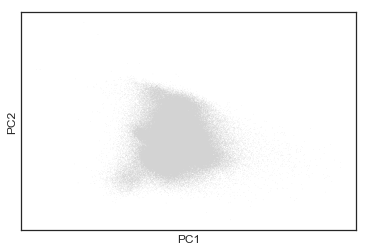

In [7]:
# Calculate PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

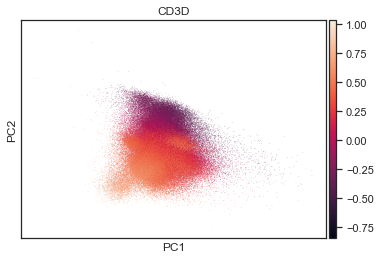

In [8]:
sc.pl.pca(adata, color='CD3D')

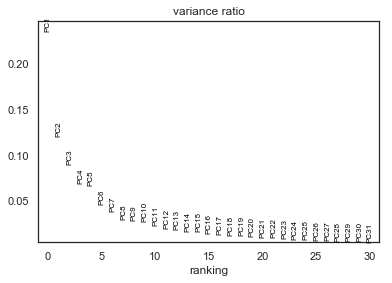

In [9]:
sc.pl.pca_variance_ratio(adata)

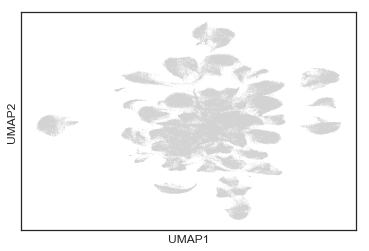

In [10]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=7)
sc.tl.umap(adata)
sc.pl.umap(adata)

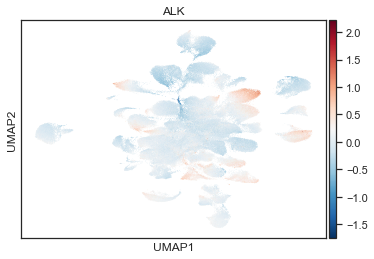

In [42]:
sc.pl.umap(adata,color='ALK', color_map="RdBu_r")

In [30]:
adata

AnnData object with n_obs × n_vars = 171304 × 35 
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

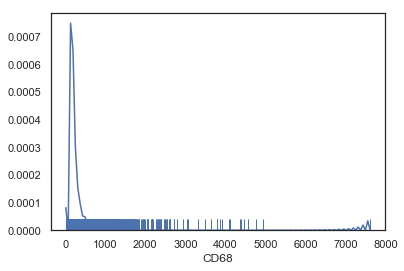

In [44]:
sns.distplot(data['CD68'], hist=False, rug=True)